In [ ]:
# Uncomment below line if you are just trying to run this notebook and have not done a full installation of this project
# !pip install pandas==2.2.3 matplotlib==3.9.3 numpy==2.0.1 sqlitedict==2.1.0 python-dotenv==1.0.1

In [ ]:
import os
import time
from pathlib import Path
import requests

from sqlitedict import SqliteDict

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

In [ ]:
# Determine the root directory and the path to the .env file
root_dir = Path.cwd().parent
dotenv_path = root_dir / ".env"

# Load the .env file
load_dotenv(dotenv_path)

In [2]:
data_directory_path = Path("../Data/1a-Collecting_Canvas_Applications/Collecting-PixiJS_Dependents")
dependents_directory_path = data_directory_path / "pixijs_dependents"
dependents_db_path = data_directory_path / "pixijs_dependents.db"

> [!NOTE]
> Before running this code, ensure you have downloaded the data (https://bit.ly/vlm_canvas_bugs-data) and placed it in the Data folder at the top-level of this repository (see the main README.md file).
>
> Alternatively, to crawl a fresh list of PixiJS dependents (i.e., overwrite the data), you would run the following commands in your terminal: 
>
> 1. `poetry shell` (if using Poetry installation)
>
> 2. `github-dependents-info --repo pixijs/pixijs --csvdirectory "./Data/1a-Collecting_Canvas_Applications/Collecting-PixiJS_Dependents/pixijs_dependents"`

##### Combine csv files into single Dataframe

In [3]:
all_dependents = pd.DataFrame(columns=["name", "stars", "package"])

for dependents_file_path in dependents_directory_path.glob("dependents_*.csv"):
    dependents = pd.read_csv(dependents_file_path, index_col=0)
    dependents["package"] = (
        dependents_file_path.name.replace(".csv", "")
        .replace("dependents_", "")
        .replace("pixi-", "pixi/")
    )
    all_dependents = pd.concat([all_dependents, dependents])

### Select projects
##### Determine selection criteria

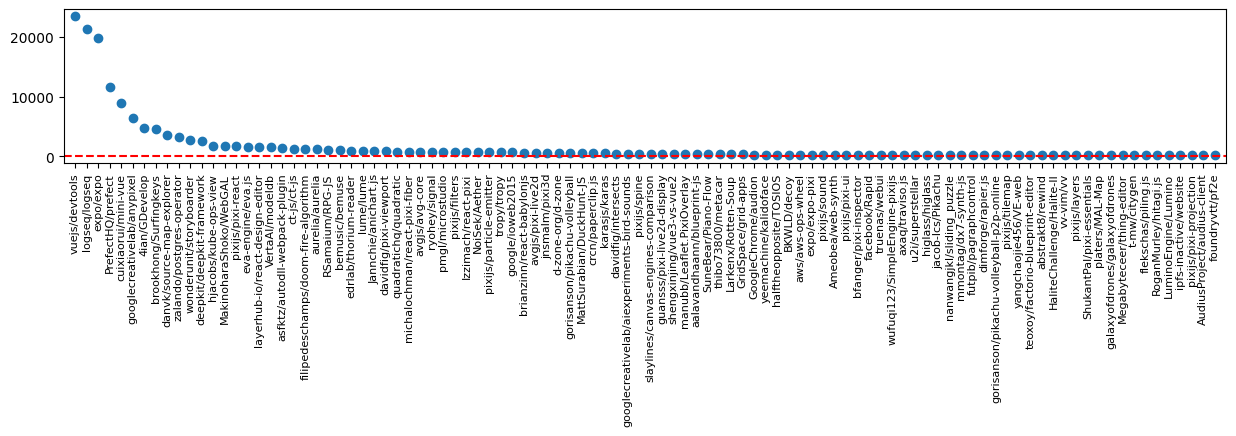

In [4]:
def plot_dependents(d, max=100, cutoff=10):
    if len(d) > max:
        d = d[:max]
    plt.figure(figsize=(15, 2))
    plt.plot(d[:, 0], d[:, 1], "o")
    plt.xticks(rotation=90, fontsize=8)
    plt.xlim(-1, len(d))
    plt.hlines(cutoff, -1, len(d), colors="r", linestyles="dashed")
    plt.show()


selection_criteria = "stars > 10 and name != 'pixijs/pixijs'"

popular_dependents = (
    all_dependents.query(selection_criteria)
    .drop_duplicates(subset=["name"])
    .sort_values(by="stars", ascending=False)
    .to_numpy()
)

plot_dependents(popular_dependents)

##### Apply selection criteria

In [ ]:
conditions_name = [
    "name != 'pixijs/pixijs'",
    "name != 'vuejs/devtools'",
]
# NOTE: After manual filtering, there were no apps that just used @pixi/app or @pixi/core (all the kept ones used pixi.js or pixi.js-legacy)
conditions_pkg = [
    "package == 'pixi.js'",
    "package == '@pixi/app'",
    "package == '@pixi/core'",
    "package == 'pixi.js-legacy'",
]
# NOTE: "stars > 10" --> threshold == 11
condition_star = "stars > 10"
query = f"({' and '.join(conditions_name)}) and ({' or '.join(conditions_pkg)}) and {condition_star}"
(
    dependents_to_crawl := all_dependents.query(query)
    .sort_values(by="stars", ascending=False)
    .drop_duplicates(subset=["name"])
    .reset_index(drop=True)
)

,name,stars,package
0,logseq/logseq,21438,pixi.js
1,expo/expo,19836,pixi.js
2,PrefectHQ/prefect,11659,pixi.js
3,cuixiaorui/mini-vue,8927,pixi.js
4,googlecreativelab/anypixel,6439,pixi.js
...,...,...,...
677,mkobayashime/fest2019-web,11,pixi.js
678,Autodesk-Forge/forge-dataviz-iot-react-components,11,pixi.js
679,RodRitter/TerraJS,11,pixi.js
680,sawa-zen/zenpad.js,11,pixi.js


In [6]:
# save the list of dependents to crawl to csv

#### UNCOMMENT AND RUN THE BELOW LINE TO OVERWRITE THE DATA
###dependents_to_crawl.to_csv(data_directory_path / "dependents_to_crawl.csv")

### Clean up memory

In [ ]:
#### UNCOMMENT AND RUN THE BELOW LINES TO CLEAR UP MEMORY IN THE NOTEBOOK
###%xdel dependents_to_crawl
###%xdel all_dependents
###%xdel dependents

NameError: name 'dependents_to_crawl' is not defined


### Crawl more data about each project
- Find PixiJS versions
- Get repository languages

###### *Using GitHub REST API v3*

> [!NOTE]
> To run the below code, ensure you have set environment variables:
> `VLM_CANVAS_BUGS_ALLOW_CRAWLING=1` and `GITHUB_API_KEY=<your_api_key>`
>
> Otherwise, the outputs of this data collection can be found in the data on Zenodo: https://bit.ly/vlm_canvas_bugs-data

In [7]:
def search_code(query):
    # use GitHub API to search for matches in test files
    # https://developer.github.com/v3/search/#search-code
    url = f"https://api.github.com/search/code?per_page=5&q={query}"
    headers = {
        "accept": "application/vnd.github.text-match+json",
        "Authorization": "token " + os.environ["GITHUB_API_KEY"],
    }
    response = requests.get(url, headers=headers)
    x_rate_limit = {
        h: response.headers[h] for h in ["X-RateLimit-Remaining", "X-RateLimit-Reset"]
    }
    return response.json(), x_rate_limit


def construct_queries(repo_name):
    pixi_keyword = [
        "pixi"
    ]
    queries = [
        f"{kw}+in:file+filename:package.json+repo:{repo_name}" for kw in pixi_keyword
    ]
    queries += [
        f"{kw}+in:file+filename:yarn.lock+repo:{repo_name}" for kw in pixi_keyword
    ]
    return queries


def download_pixi_versions(dependents, already_crawled=False, do_overwrite=False):
    if os.environ["VLM_CANVAS_BUGS_ALLOW_CRAWLING"] and not already_crawled:
        db_table_pixi_versions = SqliteDict(dependents_db_path, tablename="versions", flag="c", autocommit=True)
        x_rate_limit = None
        rate_limit = None
        count_last_checked = 0
        # search each repository with GitHub API v3 to see if they have test directory or test specs etc. that mention pixi
        for _, row in dependents.iterrows():
            print("Getting pixi version matches for " + row["name"] + "...")
            queries = construct_queries(row["name"])
            all_matches = {}
            if (not do_overwrite) and (row["name"] in db_table_pixi_versions):
                current_data = db_table_pixi_versions[row["name"]]
            else:
                current_data = {}
            for q in queries:
                if q in current_data and "total_count" in current_data[q]:
                    all_matches[q] = current_data[q]
                    continue
                print("Searching for " + q + "...")
                rate_limit, count_last_checked = respect_usage_limit(
                    type="search",
                    rate_limit=rate_limit,
                    x_rate_limit=x_rate_limit,
                    count_last_checked=count_last_checked,
                )
                matches, x_rate_limit = search_code(q)
                all_matches[q] = matches
            db_table_pixi_versions[row["name"]] = all_matches


def download_repo_languages(dependents, already_crawled=False):
    if os.environ["VLM_CANVAS_BUGS_ALLOW_CRAWLING"] and not already_crawled:
        db_table_repos = SqliteDict(dependents_db_path, tablename="repos", flag="r")
        db_table_languages = SqliteDict(
            dependents_db_path, tablename="languages", flag="c", autocommit=True
        )
        headers = {"Authorization": "token " + os.environ["GITHUB_API_KEY"]}
        rate_limit = None
        count_last_checked = 0
        for _, row in dependents.iterrows():
            rate_limit, count_last_checked = respect_usage_limit(
                type="core",
                rate_limit=rate_limit,
                count_last_checked=count_last_checked,
            )
            repo = db_table_repos[row["name"]]
            languages = requests.get(repo["languages_url"], headers=headers).json()
            db_table_languages[row["name"]] = languages


def throttle_requests(seconds=0.1):
    time.sleep(seconds)


def get_rate_limit():
    url = "https://api.github.com/rate_limit"
    headers = {"Authorization": "token " + os.environ["GITHUB_API_KEY"]}
    response = requests.get(url, headers=headers)
    return response.json()


def respect_usage_limit(
    type="core", rate_limit=None, x_rate_limit=None, count_last_checked=0
):
    throttle_requests()
    if x_rate_limit and int(x_rate_limit["X-RateLimit-Remaining"]) == 1:
        reset_time = datetime.datetime.fromtimestamp(
            int(x_rate_limit["X-RateLimit-Reset"])
        )
        sleep_until(reset_time)
    if rate_limit:
        if int(rate_limit["resources"][type]["remaining"]) <= (count_last_checked + 1):
            # getting rate limit again here slows the crawl down a little bit (might double-sleep)
            # but better than potentially exceeding the rate limit
            # logic would make more sense if got rate_limit after sleeping.
            rate_limit = get_rate_limit()
            count_last_checked = 0
            reset_time = datetime.datetime.fromtimestamp(
                int(rate_limit["resources"][type]["reset"])
            )
            sleep_until(reset_time)
        else:
            count_last_checked += 1
    else:
        rate_limit = get_rate_limit()
        count_last_checked = 0
        if int(rate_limit["resources"][type]["remaining"]) <= (count_last_checked + 1):
            # Rate limit nearly exceeded. Wait until reset time
            reset_time = datetime.datetime.fromtimestamp(
                int(rate_limit["resources"][type]["reset"])
            )
            sleep_until(reset_time)
    return rate_limit, count_last_checked


def sleep_until(end_time):
    SAFETY_INCH = datetime.timedelta(seconds=2)
    print("Sleeping until " + str(end_time + SAFETY_INCH))
    sleep_time = (end_time + SAFETY_INCH) - datetime.datetime.now()
    time.sleep(sleep_time.total_seconds())

In [ ]:
#### To overwrite the data, set the following flags to FALSE as needed (then manually switch back to TRUE once done)

ALREADY_CRAWLED_LANGUAGES = True
ALREADY_CRAWLED_VERSIONS = True

# load the list of dependents to crawl from csv
dependents_to_crawl = pd.read_csv(data_directory_path / "dependents_to_crawl.csv", index_col=0)

download_repo_languages(dependents_to_crawl, already_crawled=ALREADY_CRAWLED_LANGUAGES)
download_pixi_versions(dependents_to_crawl, already_crawled=ALREADY_CRAWLED_VERSIONS)

#### Clean up memory

In [ ]:
#### UNCOMMENT AND RUN THE BELOW LINE TO CLEAR UP MEMORY IN THE NOTEBOOK
###%xdel dependents_to_crawl

### Filter projects

In [9]:
# read the list of repository names from the database
db_table_repos = SqliteDict(dependents_db_path, tablename="repos", flag="r")
repo_names = list(db_table_repos.keys())

##### Filter by languages

In [10]:
db_table_languages = SqliteDict(dependents_db_path, tablename="languages", flag="r")

# create a dataframe of repository names and languages
(repo_languages := pd.DataFrame.from_dict(db_table_languages, orient="index").fillna(0))

,Clojure,TypeScript,JavaScript,CSS,HTML,Java,Swift,Shell,Ruby,Dockerfile,...,PowerShell,Astro,Smalltalk,Nix,Cirru,Standard ML,Common Workflow Language,Velocity Template Language,Reason,DIGITAL Command Language
logseq/logseq,3513317.0,976330.0,759205.0,554772.0,49137.0,24166.0,24089.0,7144.0,3225.0,1196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Izzimach/react-pixi,498.0,6227.0,73442.0,0.0,1173.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HaliteChallenge/Halite-II,15989.0,0.0,6941451.0,215462.0,56747.0,28548.0,27281.0,30859.0,153853.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HaliteChallenge/Halite-III,24129.0,29259.0,3620125.0,5101.0,30689.0,24922.0,57086.0,10983.0,86788.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nasser/zajal,34853.0,9061.0,3086794.0,0.0,878.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yeemachine/kalidoface,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LucasMonnanni/pixi-test,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
galaxyofdrones/galaxyofdrones,0.0,0.0,0.0,0.0,0.0,0.0,0.0,967.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fable-compiler/fable-graphics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,617.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# check which repos are not present in index of languages
not_present = list(set(repo_names) - set(repo_languages.index))

# read the default language for each not present repo from the database
db_table_repos = SqliteDict(dependents_db_path, tablename="repos", flag="r")

# for the repos that are not present in the index of languages, check their entries in language db
for repo_name in not_present:
    print(repo_name)
    print(db_table_languages[repo_name])
    print(db_table_repos[repo_name]["language"])

In [12]:
#### To overwrite the data, set the following flags to FALSE as needed (then manually switch back to TRUE once done)
ALREADY_FILLED_LANGUAGES = True

# manually check and fill languages for these repos (just the main language)
# set as infinity to represent "uncounted" (instead of "uncountable")
if not ALREADY_FILLED_LANGUAGES:
    db_table_languages = SqliteDict(
        dependents_db_path, tablename="languages", flag="c", autocommit=True
    )
    db_table_languages["manubb/Leaflet.PixiOverlay"] = {"JavaScript": np.inf}
    db_table_languages["joshellissh/pi-dgc"] = {"C++": np.inf}
    db_table_languages["yeemachine/kalidoface"] = {"JavaScript": np.inf}
    db_table_languages["LucasMonnanni/pixi-test"] = {"JavaScript": np.inf}

In [13]:
repos_filtered_languages = repo_languages.query(
    "JavaScript > 0 or TypeScript > 0"
).index.tolist()

##### Filter by Pixi Version

In [14]:
dependents_to_crawl = pd.read_csv(data_directory_path / "dependents_to_crawl.csv", index_col=0)

In [15]:
dependents_to_crawl

,name,stars,package
0,logseq/logseq,21438,pixi.js
1,expo/expo,19836,pixi.js
2,PrefectHQ/prefect,11659,pixi.js
3,cuixiaorui/mini-vue,8927,pixi.js
4,googlecreativelab/anypixel,6439,pixi.js
...,...,...,...
677,mkobayashime/fest2019-web,11,pixi.js
678,Autodesk-Forge/forge-dataviz-iot-react-components,11,pixi.js
679,RodRitter/TerraJS,11,pixi.js
680,sawa-zen/zenpad.js,11,pixi.js


In [ ]:
# read the list of repository names from the database
db_table_versions = SqliteDict(dependents_db_path, tablename="versions", flag="r")
repo_names = list(db_table_versions.keys())

In [ ]:
matched_lines = {}
matched_fragments = {}
missing = {}
no_matches = []

for repo_name in db_table_versions:
    found_match = False
    queries_results = db_table_versions[repo_name]

    for query in queries_results:
        results = queries_results[query]

        if found_match:
            break

        if results:

            for item in results["items"]:

                if found_match:
                    break

                for match in item["text_matches"]:

                    if found_match:
                        break

                    lines = match["fragment"].split("\n")

                    for line in lines:

                        if found_match:
                            break

                        if "\"pixi.js\"" in line:
                            found_match = True
                            matched_lines[repo_name] = line
                            matched_fragments[repo_name] = match["fragment"]

                    if found_match:
                        break

                    for line in lines:

                        if found_match:
                            break

                        if "pixi.js:" in line or "\"@pixi" in line:
                            found_match = True
                            matched_lines[repo_name] = line
                            matched_fragments[repo_name] = match["fragment"]

    if not found_match:
        has_no_matches_whatsoever = True

        for q in queries_results:

            if queries_results[q]["total_count"] > 0:
                has_no_matches_whatsoever = False

        if has_no_matches_whatsoever:
            no_matches.append(repo_name)
        else:
            missing[repo_name] = queries_results

#### NOTE: If using the already completed data (instead of crawling new data):
####  --> these numbers will be the same as a below cell (after crawling for more data), 
####      as the versions get filled in the DB in a lower cell
print("matched", len(matched_lines))
print("missing", len(missing))
print("no matches whatsoever", len(no_matches))

In [68]:
#### NOTE: If using the already completed data (instead of crawling new data):
#### Set the following flags to FALSE as needed (then manually switch back to TRUE once done)
ALREADY_FILLED_VERSIONS = True

if not ALREADY_FILLED_VERSIONS:
    for m in missing:
        for q in missing[m]:
            if missing[m][q]['total_count'] != 0:
                for item in missing[m][q]['items']:
                    print(item["repository"]["name"])
                    for match in item["text_matches"]:
                        print(match["fragment"])
                    print("\n")

# after checking, can see remaining matches are just descriptions mentioning pixi.js or the version of the project itself, not of pixi.js

In [69]:
def construct_queries_broader_search(repo_name):
    pixi_keyword = [
        "pixi"
    ]
    queries = [
        f"{kw}+in:file+filename:package-lock.json+repo:{repo_name}" for kw in pixi_keyword
    ]
    return queries

def download_pixi_versions_broader_search(dependents_list, already_crawled=False, do_overwrite=False):
    if os.environ["ALLOW_CRAWLING"] and not already_crawled:
        db_table_pixi_versions = SqliteDict(dependents_db_path, tablename="versions", flag="c", autocommit=True)
        x_rate_limit = None
        rate_limit = None
        count_last_checked = 0
        # search each repository with GitHub API v3 to see if they have test directory or test specs etc. that mention pixi
        for repo_name in dependents_list:
            print("Getting pixi version matches for " + repo_name + "...")
            queries = construct_queries_broader_search(repo_name)
            all_matches = {}
            if (not do_overwrite) and (repo_name in db_table_pixi_versions):
                current_data = db_table_pixi_versions[repo_name]
            else:
                current_data = {}
            for q in queries:
                if q in current_data and "total_count" in current_data[q]:
                    all_matches[q] = current_data[q]
                    continue
                print("Searching for " + q + "...")
                rate_limit, count_last_checked = respect_usage_limit(
                    type="search",
                    rate_limit=rate_limit,
                    x_rate_limit=x_rate_limit,
                    count_last_checked=count_last_checked,
                )
                matches, x_rate_limit = search_code(q)
                all_matches[q] = matches
            db_table_pixi_versions[repo_name] = all_matches

In [70]:
#### To overwrite the data, set the following flags to FALSE as needed (then manually switch back to TRUE once done)
ALREADY_FILLED_VERSIONS = True

# redo crawl in package-lock.json for repos in no_matches and missing
repos_to_recrawl = no_matches + list(missing.keys())
download_pixi_versions_broader_search(repos_to_recrawl, already_crawled=ALREADY_FILLED_VERSIONS)

In [90]:
db_table_pixi_versions = SqliteDict(dependents_db_path, tablename="versions", flag="r")
matched_lines = {}
matched_fragments = {}
missing = {}
no_matches = []

for repo_name in db_table_pixi_versions:
    found_match = False
    queries_results = db_table_pixi_versions[repo_name]

    for query in queries_results:
        results = queries_results[query]

        if found_match:
            break

        if results:

            for item in results["items"]:

                if found_match:
                    break

                for match in item["text_matches"]:

                    if found_match:
                        break

                    lines = match["fragment"].split("\n")

                    for line in lines:

                        if found_match:
                            break

                        if "\"pixi.js\"" in line:
                            found_match = True
                            matched_lines[repo_name] = line
                            matched_fragments[repo_name] = match["fragment"]

                    if found_match:
                        break

                    for line in lines:

                        if found_match:
                            break

                        if "pixi.js:" in line or "\"@pixi" in line:
                            found_match = True
                            matched_lines[repo_name] = line
                            matched_fragments[repo_name] = match["fragment"]

    if not found_match:
        has_no_matches_whatsoever = True

        for q in queries_results:

            if queries_results[q]["total_count"] > 0:
                has_no_matches_whatsoever = False

        if has_no_matches_whatsoever:
            no_matches.append(repo_name)
        else:
            missing[repo_name] = queries_results

print("matched", len(matched_lines))
print("missing", len(missing))
print("no matches whatsoever", len(no_matches))

matched 444
missing 78
no matches whatsoever 160


In [92]:
# manually added to google sheet
for k,v in matched_lines.items():
    print(k, " ", v)

logseq/logseq           "pixi.js": "6.2.0",
expo/expo       "pixi.js": "^4.6.1",
cuixiaorui/mini-vue       "pixi.js": "^6.2.0"
googlecreativelab/anypixel       "pixi.js": "^3.0.9",
4ian/GDevelop       "pixi.js": "7.3.0",
brookhong/Surfingkeys       "@pixi/math": "^7.4.0",
danvk/source-map-explorer       "pixi.js": "^5.2.3",
zalando/postgres-operator       "pixi.js": "^7.1.1"
deepkit/deepkit-framework       "pixi.js": "^5.3.8",
pixijs/pixi-react       "@pixi/extensions": "^7.1.1",
eva-engine/eva.js       "pixi.js": "^4.8.9"
VertaAI/modeldb       "pixi.js": "^5.2.1",
asfktz/autodll-webpack-plugin       "pixi.js": "^4.5.3",
ct-js/ct-js       "@pixi/particle-emitter": "5.0.8",
filipedeschamps/doom-fire-algorithm       "pixi.js": "^4.8.5"
RSamaium/RPG-JS       "@pixi/tilemap": "^4.0.0",
bemusic/bemuse       "pixi.js": "^4.8.9",
quadratichq/quadratic       "pixi.js": "^6.5.1",
michalochman/react-pixi-fiber       "pixi.js": "^6.0.4",
avgjs/avg-core       "pixi.js": "^4.5.4",
pixijs/filters   

In [94]:
# manually verified whether these have a matching pixi.js version 
# see spreadsheet: Data/1a-Collecting_Canvas_Applications/Manual_Filtering-PixiJS_Dependents.xlsx
# manually added to the google sheet

list_repos_missing_pixijs_version = []


for k in missing:
    list_repos_missing_pixijs_version.append(k)


for r in no_matches:
    # print(r)

    if isinstance(r, dict):
        list_repos_missing_pixijs_version += r.keys()

    else:
        list_repos_missing_pixijs_version.append(r)


list_repos_missing_pixijs_version
    

['davidfig/pixi-viewport',
 'Izzimach/react-pixi',
 'avgjs/pixi-live2d',
 'slaylines/canvas-engines-comparison',
 'guansss/pixi-live2d-display',
 'nanwangjkl/sliding_puzzle',
 'pixijs/layers',
 'shakogegia/markdown-editor',
 'yordan-kanchelov/pixi-typescript-boilerplate',
 'vote4hk/warsinhk',
 'epam/NGB',
 'blastrain/pixi-after-effects',
 'phiresky/procedural-cities',
 'pixijs/animate-extension',
 'davidfig/pixi-cull',
 'Nazariglez/pixi-tween',
 'slashman/jsrl',
 'PixelsCommander/pixi-sdf-text',
 'EvanBacon/snake',
 'avgjs/pixi-richtext',
 'Granipouss/vue-pixi',
 'gamestdio/pixi-engine',
 'EvanBacon/react-flappy-bird',
 'hustcc/pixi-action',
 'zaaack/inker',
 'dacaher/pixijs-ts-boilerplate',
 'saschagehlich/pixi-svg-graphics',
 'recative/recative-system',
 'yahiko00/PixiProject',
 'Prozi/pixi-shim',
 'EvanBacon/expo-doodle-jump',
 'yordan-kanchelov/pixi-console',
 'bma73/revolt-fx',
 'ltruchot/seed-pixi-typescript',
 'LAGameStudio/pixitron',
 'itsezc/CycloneIO',
 'Nazariglez/pixi-audio

In [91]:
# manually inspect missing
for k, v in missing.items():
    print(k)
    for i in v:
        for j in v[i]["items"]:
            for t in j["text_matches"]:
                print(t["fragment"])
    print("\n")

davidfig/pixi-viewport
    "version": "5.0.3",
    "description": "A highly configurable viewport/2D camera designed to work with pixi.js. Features include dragging, pinch-to-zoom, mouse wheel zooming, decelerated dragging, follow target, snap to point, snap to zoom, clamping, bouncing on edges, and move on mouse edges.",
    "main": "./dist/pixi_viewport.umd.cjs",
        "type": "git",
        "url": "git+https://github.com/davidfig/pixi-viewport.git"
    },


Izzimach/react-pixi
  "version": "0.9.19",
  "description": "Construct PIXI.js scenes using React",
  "keywords": [
    "type": "git",
    "url": "https://github.com/Izzimach/react-pixi"
  },


avgjs/pixi-live2d
{
  "name": "pixi-live2d",
  "version": "1.2.1",
  "description": "Display live2D model as a sprite in pixi.js.",
  "main": "dist/pixi-live2d.js",
  "scripts": {
    "prepublish": "npm run build",


slaylines/canvas-engines-comparison
  "version": "1.0.0",
  "default": "src/pages/pixi.pug",
  "repository": "https://gith

### Inspect and manually filter

- [Link to Excel spreadsheet in this repository](../Data/1a-Collecting_Canvas_Applications/Manual_Filtering-PixiJS_Dependents.xlsx)

#### To assist with manual filtering: Do one more really wide search to match any PixiJS mentions

**Created  `missing.csv` file from that was data copied into google sheet (final version named `Manual_Filtering-PixiJS_Dependents.xlsx`)**

In [ ]:
def github_search_repo_for_version(repo_name, x_rate_limit, rate_limit=None, count_last_checked=0):
    if os.environ["VLM_CANVAS_BUGS_ALLOW_CRAWLING"]:
        q = f"pixi+in:file+repo:{repo_name}"
        print("Searching for " + q + "...")
        rate_limit, count_last_checked = respect_usage_limit(
            type="search",
            rate_limit=rate_limit,
            x_rate_limit=x_rate_limit,
            count_last_checked=count_last_checked,
        )
        matches, x_rate_limit = search_code(q)
        return matches, x_rate_limit


def search_code(query):
    if os.environ["VLM_CANVAS_BUGS_ALLOW_CRAWLING"]:
        # use GitHub API to search for matches in test files
        # https://developer.github.com/v3/search/#search-code
        url = f"https://api.github.com/search/code?per_page=5&q={query}"
        headers = {
            "accept": "application/vnd.github.text-match+json",
            "Authorization": "token " + os.environ["GITHUB_API_KEY"],
        }
        response = requests.get(url, headers=headers)
        x_rate_limit = {
            h: response.headers[h] for h in ["X-RateLimit-Remaining", "X-RateLimit-Reset"]
        }
        return response.json(), x_rate_limit


def throttle_requests(seconds=0.1):
    time.sleep(seconds)


def get_rate_limit():
    url = "https://api.github.com/rate_limit"
    headers = {"Authorization": "token " + os.environ["GITHUB_API_KEY"]}
    response = requests.get(url, headers=headers)
    return response.json()


def respect_usage_limit(
    type="core", rate_limit=None, x_rate_limit=None, count_last_checked=0
):
    throttle_requests()
    if x_rate_limit and int(x_rate_limit["X-RateLimit-Remaining"]) == 1:
        reset_time = datetime.datetime.fromtimestamp(
            int(x_rate_limit["X-RateLimit-Reset"])
        )
        sleep_until(reset_time)
    if rate_limit:
        if int(rate_limit["resources"][type]["remaining"]) <= (count_last_checked + 1):
            # getting rate limit again here slows the crawl down a little bit (might double-sleep)
            # but better than potentially exceeding the rate limit
            # logic would make more sense if got rate_limit after sleeping.
            rate_limit = get_rate_limit()
            count_last_checked = 0
            reset_time = datetime.datetime.fromtimestamp(
                int(rate_limit["resources"][type]["reset"])
            )
            sleep_until(reset_time)
        else:
            count_last_checked += 1
    else:
        rate_limit = get_rate_limit()
        count_last_checked = 0
        if int(rate_limit["resources"][type]["remaining"]) <= (count_last_checked + 1):
            # Rate limit nearly exceeded. Wait until reset time
            reset_time = datetime.datetime.fromtimestamp(
                int(rate_limit["resources"][type]["reset"])
            )
            sleep_until(reset_time)
    return rate_limit, count_last_checked


def sleep_until(end_time):
    SAFETY_INCH = datetime.timedelta(seconds=2)
    print("Sleeping until " + str(end_time + SAFETY_INCH))
    sleep_time = (end_time + SAFETY_INCH) - datetime.datetime.now()
    time.sleep(sleep_time.total_seconds())

In [ ]:
#### To overwrite the data, set the following flags to FALSE as needed (then manually switch back to TRUE once done)
ALREADY_DID_WIDE_SEARCH_ON_MISSING_VERSIONS = True

extra_wide_search_directory_path = data_directory_path / "extra_wide_version_search"

if not ALREADY_DID_WIDE_SEARCH_ON_MISSING_VERSIONS:

    missing_version = pd.read_csv(extra_wide_search_directory_path / "missing_version.csv")
    matches = {}
    x_rate_limit = None

    for r in missing_version["repo_name_with_owner"]:
        if r in matches.keys():
            print(f"Already have {r} matches")
        matches[r], x_rate_limit = github_search_repo_for_version(r, x_rate_limit)
        print(r)
        # print(matches[r])
        print()

In [115]:
if not ALREADY_DID_WIDE_SEARCH_ON_MISSING_VERSIONS:
    df_matches = pd.DataFrame.from_dict(matches, orient="index")
    df_matches.to_csv(extra_wide_search_directory_path / "matches.csv")

In [118]:
# This code also requires that the code in above cells was run (to create the `matches` variable)
if not ALREADY_DID_WIDE_SEARCH_ON_MISSING_VERSIONS:

    has_match = {}

    for k,v in matches.items():
        print(k)
        if v["total_count"] == 0:
            has_match[k] = False
        else:
            has_match[k] = ""
            
        for item in v["items"]:
            for match in item["text_matches"]:
                # print(match["object_url"])
                # print(match["fragment"])
                # print()
                if "6." in match["fragment"] or "7." in match["fragment"]:
                    print(match["fragment"])
        print("-----------------------------------------------------")

In [119]:
if not ALREADY_DID_WIDE_SEARCH_ON_MISSING_VERSIONS:
    pd.DataFrame.from_dict(has_match, orient="index").to_csv(extra_wide_search_directory_path / "has_match.csv")

### Inspect and continue manually filtering

- [Link to Excel spreadsheet in this repository](../Data/1a-Collecting_Canvas_Applications/Manual_Filtering-PixiJS_Dependents.xlsx)

-----